# DenseNet baseline test

In [23]:
import numpy as np
import pandas as pd
import h5py
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from torchvision import transforms, models
from torchvision.models import densenet121, DenseNet121_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from dataset import HDF5Dataset
from sklearn.metrics import roc_auc_score, roc_curve
from isic_metric import score

## Preprocess Data

In [24]:
# Load metadata
metadata = pd.read_csv("../train-metadata.csv")
hdf5 = h5py.File("../train-image.hdf5", "r")

# Sample balanced malignant and benign
malignant_ids = metadata[metadata["target"] == 1].sample(n=393, random_state=42)["isic_id"].tolist()
benign_ids = metadata[metadata["target"] == 0].sample(n=393, random_state=42)["isic_id"].tolist()

def load_images(ids):
    images = []
    labels = []
    for image_id in ids:
        image = hdf5[image_id][()]
        image = np.frombuffer(image, dtype=np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (128, 128))
        images.append(image)
        labels.append(1 if image_id in malignant_ids else 0)
    return images, labels

images_mal, labels_mal = load_images(malignant_ids)
images_ben, labels_ben = load_images(benign_ids)

# Combine and split
all_images = np.array(images_mal + images_ben)
all_labels = np.array(labels_mal + labels_ben)

X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.1, stratify=all_labels, random_state=42)

/tmp/ipykernel_1990395/2231450438.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("../train-metadata.csv")


## Train

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
weights = DenseNet121_Weights.DEFAULT
transform = weights.transforms()
model = densenet121(weights=weights)
model.classifier = nn.Linear(model.classifier.in_features, 1)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [27]:
train_dataset = HDF5Dataset(X_train, y_train, augment=True, transform=transform)
val_dataset = HDF5Dataset(X_val, y_val, augment=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)

In [28]:
num_epochs = 20
train_losses, val_losses = [], []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []
partial_aucs = []
# partial AUC, used to compare between models 
# v_gt = abs(np.asarray(Y_test) - 1)
# v_pred = np.array([1.0 - x for x in Y_probs])
# max_fpr = abs(1 - min_tpr)
# partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=0.8)
# partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

In [31]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # [B, 1]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # === Validation ===
    model.eval()
    val_loss = 0
    preds, targets = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_auc = roc_auc_score(targets, preds)
    
    # Threshold predictions at 0.5
    pred_labels = (np.array(preds) >= 0.5).astype(int)
    true_labels = np.array(targets).astype(int)

    
    # Partial AUC Computation 
    true_labels = np.array(targets).astype(int).flatten()
    preds = np.array(preds).flatten()
    df_sol = pd.DataFrame({
        "image_id": list(range(len(true_labels))),
        "target": true_labels
    })
    
    df_sub = pd.DataFrame({
        "image_id": list(range(len(preds))),
        "target": preds  # prediction probabilities
    })
    
    # Compute pAUC from official metric
    pauc = score(df_sol, df_sub, row_id_column_name="image_id", min_tpr=0.80)
    partial_aucs.append(pauc)
    
    val_acc = accuracy_score(true_labels, pred_labels)
    val_precision = precision_score(true_labels, pred_labels)
    val_recall = recall_score(true_labels, pred_labels)
    val_f1 = f1_score(true_labels, pred_labels)

    print(f"Epoch {epoch+1}: Acc = {val_acc:.4f}, Precision = {val_precision:.4f}, Recall = {val_recall:.4f}, F1 = {val_f1:.4f}, pAUC = {pauc:.4f}")    
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1],
        'val_auc': val_auc
    }, f"checkpoints/DenseNet_epoch_{epoch+1}.pth")

Epoch 1/20: 100%|██████████| 23/23 [00:02<00:00,  8.58it/s]


Epoch 1: Acc = 0.6709, Precision = 0.6444, Recall = 0.7436, F1 = 0.6905, pAUC = 0.0614


Epoch 2/20: 100%|██████████| 23/23 [00:02<00:00,  8.61it/s]


Epoch 2: Acc = 0.6835, Precision = 0.6591, Recall = 0.7436, F1 = 0.6988, pAUC = 0.0824


Epoch 3/20: 100%|██████████| 23/23 [00:02<00:00,  8.52it/s]


Epoch 3: Acc = 0.7342, Precision = 0.7143, Recall = 0.7692, F1 = 0.7407, pAUC = 0.0992


Epoch 4/20: 100%|██████████| 23/23 [00:02<00:00,  8.48it/s]


Epoch 4: Acc = 0.7342, Precision = 0.7368, Recall = 0.7179, F1 = 0.7273, pAUC = 0.0982


Epoch 5/20: 100%|██████████| 23/23 [00:02<00:00,  8.49it/s]


Epoch 5: Acc = 0.7595, Precision = 0.7632, Recall = 0.7436, F1 = 0.7532, pAUC = 0.1001


Epoch 6/20: 100%|██████████| 23/23 [00:02<00:00,  8.50it/s]


Epoch 6: Acc = 0.7722, Precision = 0.7838, Recall = 0.7436, F1 = 0.7632, pAUC = 0.0972


Epoch 7/20: 100%|██████████| 23/23 [00:02<00:00,  8.51it/s]


Epoch 7: Acc = 0.7848, Precision = 0.8056, Recall = 0.7436, F1 = 0.7733, pAUC = 0.1049


Epoch 8/20: 100%|██████████| 23/23 [00:02<00:00,  8.51it/s]


Epoch 8: Acc = 0.7975, Precision = 0.8108, Recall = 0.7692, F1 = 0.7895, pAUC = 0.1041


Epoch 9/20: 100%|██████████| 23/23 [00:02<00:00,  8.47it/s]


Epoch 9: Acc = 0.8228, Precision = 0.8788, Recall = 0.7436, F1 = 0.8056, pAUC = 0.1004


Epoch 10/20: 100%|██████████| 23/23 [00:02<00:00,  8.51it/s]


Epoch 10: Acc = 0.8101, Precision = 0.8158, Recall = 0.7949, F1 = 0.8052, pAUC = 0.1031


Epoch 11/20: 100%|██████████| 23/23 [00:02<00:00,  8.57it/s]


Epoch 11: Acc = 0.8481, Precision = 0.9091, Recall = 0.7692, F1 = 0.8333, pAUC = 0.0910


Epoch 12/20: 100%|██████████| 23/23 [00:02<00:00,  8.57it/s]


Epoch 12: Acc = 0.8354, Precision = 0.8611, Recall = 0.7949, F1 = 0.8267, pAUC = 0.0942


Epoch 13/20: 100%|██████████| 23/23 [00:02<00:00,  8.56it/s]


Epoch 13: Acc = 0.7975, Precision = 0.7949, Recall = 0.7949, F1 = 0.7949, pAUC = 0.0936


Epoch 14/20: 100%|██████████| 23/23 [00:02<00:00,  8.58it/s]


Epoch 14: Acc = 0.8101, Precision = 0.8158, Recall = 0.7949, F1 = 0.8052, pAUC = 0.0923


Epoch 15/20: 100%|██████████| 23/23 [00:02<00:00,  8.55it/s]


Epoch 15: Acc = 0.8101, Precision = 0.8158, Recall = 0.7949, F1 = 0.8052, pAUC = 0.0979


Epoch 16/20: 100%|██████████| 23/23 [00:03<00:00,  7.39it/s]


Epoch 16: Acc = 0.8228, Precision = 0.8378, Recall = 0.7949, F1 = 0.8158, pAUC = 0.1013


Epoch 17/20: 100%|██████████| 23/23 [00:02<00:00,  8.54it/s]


Epoch 17: Acc = 0.7722, Precision = 0.7561, Recall = 0.7949, F1 = 0.7750, pAUC = 0.0942


Epoch 18/20: 100%|██████████| 23/23 [00:02<00:00,  8.52it/s]


Epoch 18: Acc = 0.8228, Precision = 0.8571, Recall = 0.7692, F1 = 0.8108, pAUC = 0.0923


Epoch 19/20: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Epoch 19: Acc = 0.7722, Precision = 0.7561, Recall = 0.7949, F1 = 0.7750, pAUC = 0.0981


Epoch 20/20: 100%|██████████| 23/23 [00:02<00:00,  8.07it/s]


Epoch 20: Acc = 0.7975, Precision = 0.7949, Recall = 0.7949, F1 = 0.7949, pAUC = 0.0891


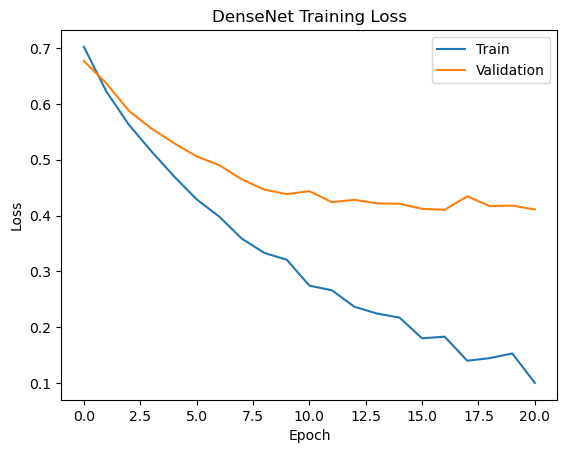

In [32]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DenseNet Training Loss")
plt.legend()
plt.savefig("DenseNet_loss_curve.png")

FileNotFoundError: [Errno 2] No such file or directory: 'plots/partial_auc_curve.png'

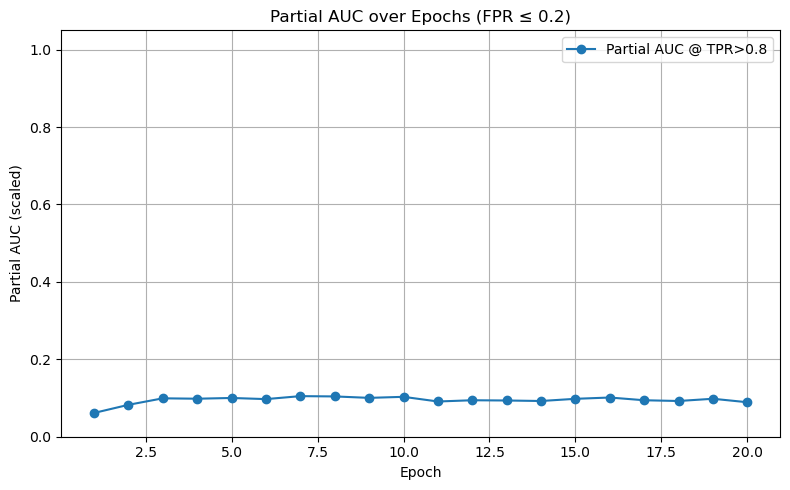

In [33]:
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, partial_aucs, marker='o', label="Partial AUC @ TPR>0.8")
plt.title("Partial AUC over Epochs (FPR ≤ 0.2)")
plt.xlabel("Epoch")
plt.ylabel("Partial AUC (scaled)")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("plots/partial_auc_curve.png")
plt.show()